Data directory: /Users/wangyang/Desktop/Liver_cancer/16-AIDD/08_molecular_dynamics_simulation/data
Extracted SMILES: OC1NC2CCCCC2N1C1CCN(CC2CCC(C3NC4CC5NCNC5CC4NC3C3CCCCC3)CC2)CC1


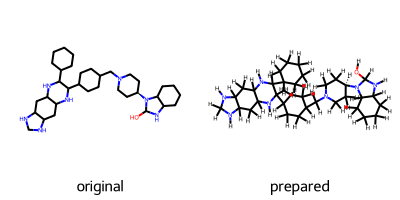

Warning (not error because allow_undefined_stereo=True): RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 0)
 - Atom C (index 10)
 - Atom C (index 12)
 - Atom C (index 14)
 - Atom C (index 25)
 - Atom C (index 27)
 - Atom C (index 28)
 - Atom C (index 29)
 - Atom C (index 31)



Stereochemistry assigned successfully.


Warning (not error because allow_undefined_stereo=True): RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 0)
 - Atom C (index 10)
 - Atom C (index 12)
 - Atom C (index 14)
 - Atom C (index 25)
 - Atom C (index 27)
 - Atom C (index 28)
 - Atom C (index 29)
 - Atom C (index 31)



Complex topology has 7143 atoms.


Did not recognize residue IQO; did you forget to call .add_molecules() to add it?


ValueError: No template found for residue 450 (IQO).  This might mean your input topology is missing some atoms or bonds, or possibly that you are using the wrong force field.  For more information, see https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#template

In [5]:
import copy
from pathlib import Path
import os
import sys
import numpy as np
from IPython.display import display
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import mdtraj as md
import pdbfixer
import openmm as mm
import openmm.app as app
from openmm import unit
from openff.toolkit.topology import Molecule
from openmmforcefields.generators import GAFFTemplateGenerator

# 设置工作目录
HERE = Path(os.getcwd())
DATA = HERE / 'data'
if not DATA.exists():
    DATA.mkdir(parents=True, exist_ok=True)
print(f"Data directory: {DATA}")

# 配置信息
pdbid = "3O96"  # PDB 文件 ID
ligand_name = "IQO"  # 配体名称
pdb_path = DATA / f"{pdbid}.pdb"

# 函数：准备蛋白
def prepare_protein(
    pdb_file, ignore_missing_residues=True, ignore_terminal_missing_residues=True, ph=7.0
):
    """
    Use pdbfixer to prepare the protein from a PDB file. Removes heteroatoms and adds missing atoms.
    """
    fixer = pdbfixer.PDBFixer(str(pdb_file))
    fixer.removeHeterogens()  # 移除配体或其他非标准残基
    fixer.findMissingResidues()  # 查找缺失残基
    if ignore_terminal_missing_residues:
        chains = list(fixer.topology.chains())
        for key in list(fixer.missingResidues.keys()):
            chain = chains[key[0]]
            if key[1] == 0 or key[1] == len(list(chain.residues())):
                del fixer.missingResidues[key]
    if ignore_missing_residues:
        fixer.missingResidues = {}
    fixer.findNonstandardResidues()  # 查找非标准残基
    fixer.replaceNonstandardResidues()  # 替换非标准残基为标准残基
    fixer.findMissingAtoms()  # 查找缺失的原子
    fixer.addMissingAtoms()  # 补充缺失的原子
    fixer.addMissingHydrogens(ph)  # 添加氢原子
    return fixer

# 函数：准备配体
def prepare_ligand_auto(pdb_file, resname, depict=True):
    """
    从 PDB 文件中提取配体并进行预处理（自动生成 SMILES）。
    """
    rdkit_mol = Chem.MolFromPDBFile(str(pdb_file))
    rdkit_mol_split = Chem.rdmolops.SplitMolByPDBResidues(rdkit_mol)
    if resname not in rdkit_mol_split:
        raise ValueError(f"Residue {resname} not found in PDB file.")
    ligand = rdkit_mol_split[resname]
    ligand = Chem.RemoveHs(ligand)
    smiles = Chem.MolToSmiles(ligand)
    print(f"Extracted SMILES: {smiles}")
    reference_mol = Chem.MolFromSmiles(smiles)
    prepared_ligand = AllChem.AssignBondOrdersFromTemplate(reference_mol, ligand)
    prepared_ligand.AddConformer(ligand.GetConformer(0))
    prepared_ligand = Chem.rdmolops.AddHs(prepared_ligand, addCoords=True)
    if depict:
        ligand_2d = copy.deepcopy(ligand)
        prepared_ligand_2d = copy.deepcopy(prepared_ligand)
        AllChem.Compute2DCoords(ligand_2d)
        AllChem.Compute2DCoords(prepared_ligand_2d)
        display(
            Draw.MolsToGridImage(
                [ligand_2d, prepared_ligand_2d], molsPerRow=2, legends=["original", "prepared"]
            )
        )
    return prepared_ligand

# 函数：为配体分配手性
def assign_stereochemistry(rdkit_mol):
    """
    为 RDKit 分子分配立体化学信息。
    """
    try:
        Chem.AssignStereochemistry(rdkit_mol, cleanIt=True, force=True)
        print("Stereochemistry assigned successfully.")
    except Exception as e:
        print(f"Error assigning stereochemistry: {e}")

# 函数：将 RDKit 分子转换为 OpenMM 分子
def rdkit_to_openmm(rdkit_mol, name="LIG"):
    """
    Convert an RDKit molecule to an OpenMM molecule.
    """
    assign_stereochemistry(rdkit_mol)
    off_mol = Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)
    off_mol.name = name
    element_counter_dict = {}
    for off_atom, rdkit_atom in zip(off_mol.atoms, rdkit_mol.GetAtoms()):
        element = rdkit_atom.GetSymbol()
        element_counter_dict[element] = element_counter_dict.get(element, 0) + 1
        off_atom.name = f"{element}{element_counter_dict[element]}"
    off_mol_topology = off_mol.to_topology()
    mol_topology = off_mol_topology.to_openmm()
    mol_positions = off_mol.conformers[0].to("nanometers")
    return app.Modeller(mol_topology, mol_positions)

# 函数：合并蛋白和配体
def merge_protein_and_ligand(protein, ligand):
    """
    Merge protein and ligand into a single system.
    """
    md_protein_topology = md.Topology.from_openmm(protein.topology)
    md_ligand_topology = md.Topology.from_openmm(ligand.topology)
    md_complex_topology = md_protein_topology.join(md_ligand_topology)
    complex_topology = md_complex_topology.to_openmm()
    total_atoms = len(protein.positions) + len(ligand.positions)
    complex_positions = unit.Quantity(np.zeros([total_atoms, 3]), unit=unit.nanometers)
    complex_positions[: len(protein.positions)] = protein.positions
    complex_positions[len(protein.positions):] = ligand.positions
    return complex_topology, complex_positions

# 函数：生成力场
def generate_forcefield(rdkit_mol, protein_ff="amber14-all.xml", solvent_ff="amber14/tip3pfb.xml"):
    """
    Generate an OpenMM Forcefield object and register a ligand using GAFFTemplateGenerator.
    """
    forcefield = app.ForceField(protein_ff, solvent_ff)
    gaff = GAFFTemplateGenerator(
        molecules=Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)
    )
    forcefield.registerTemplateGenerator(gaff.generator)
    return forcefield

# 准备蛋白
prepared_protein = prepare_protein(pdb_path, ignore_missing_residues=False)

# 自动提取和准备配体
rdkit_ligand = prepare_ligand_auto(pdb_path, ligand_name)

# 转换为 OpenMM 格式
omm_ligand = rdkit_to_openmm(rdkit_ligand, ligand_name)

# 合并蛋白和配体
complex_topology, complex_positions = merge_protein_and_ligand(prepared_protein, omm_ligand)
print(f"Complex topology has {complex_topology.getNumAtoms()} atoms.")

# 生成力场并注册配体
forcefield = generate_forcefield(rdkit_ligand)

# 添加溶剂并创建系统
modeller = app.Modeller(complex_topology, complex_positions)
modeller.addSolvent(forcefield, padding=1.0 * unit.nanometers, ionicStrength=0.15 * unit.molar)

# 创建系统
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME)
integrator = mm.LangevinIntegrator(
    300 * unit.kelvin, 1.0 / unit.picoseconds, 2.0 * unit.femtoseconds
)
simulation = app.Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

# 能量最小化
simulation.minimizeEnergy()
with open(DATA / "topology.pdb", "w") as pdb_file:
    app.PDBFile.writeFile(
        simulation.topology,
        simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions(),
        file=pdb_file,
        keepIds=True,
    )

# 动力学模拟
steps = 50000  # 100 ps
write_interval = 5000  # 每 10 ps 写一次
log_interval = 2500  # 每 5 ps 打印日志

simulation.reporters.append(
    md.reporters.XTCReporter(file=str(DATA / "trajectory.xtc"), reportInterval=write_interval)
)
simulation.reporters.append(
    app.StateDataReporter(
        sys.stdout,
        log_interval,
        step=True,
        potentialEnergy=True,
        temperature=True,
        progress=True,
        remainingTime=True,
        speed=True,
        totalSteps=steps,
        separator="\t",
    )
)

simulation.context.setVelocitiesToTemperature(300 * unit.kelvin)
simulation.step(steps)

# 验证轨迹是否存在
assert (DATA / "trajectory.xtc").stat().st_size > 0
print("Simulation")
